# Gas Dosing Demo

I created a makefile to make interacting with the Demo easier: 

Start Docker containers with the SEC Nodes running on port 10800 (gas_dosing) and 10801 (reactorcell):

 ``` make sim```

Start Containers and additionally start frappy gui:

```make frappy``` 

In [1]:
import numpy as np
from bluesky import RunEngine
import bluesky.plan_stubs as bps
from bluesky.plan_stubs import sleep, rd
from bluesky.plans import scan, count

import databroker

from bluesky.preprocessors import run_decorator, SupplementalData
from bluesky import preprocessors as bpp
from bluesky.callbacks.best_effort import BestEffortCallback
from pprint import pprint
from secop_ophyd.SECoPDevices import SECoPNodeDevice
from bluesky.utils import ProgressBarManager

from tiled.client import from_uri
import NexusCreator

import time
from ophyd.status import Status


from bluesky.log import config_bluesky_logging

config_bluesky_logging(level='WARNING')
# Create a run engine and a temporary file backed database. Send all the documents from the RE into that database
RE = RunEngine({},call_returns_result=True)
bec = BestEffortCallback()
RE.subscribe(bec)
RE.waiting_hook = ProgressBarManager()
RE.ignore_callback_exceptions = False



#Example of adding metadata to RE environment
investigation_id = "Nexus Demonstrator"

RE.md["investigation_id"] = investigation_id


client = from_uri("http://localhost:8000",api_key="secret")

def post_document(name,doc):
    client.post_document(name, doc)
    
RE.subscribe(post_document)

# Connect to Gas Dosing SEC Node and generate ophyd device tree
gas_dosing =  SECoPNodeDevice.create('localhost','10800',RE.loop)

# Connect to Reactor Cell SEC Node and generate ophyd device tree
reactor_cell =  SECoPNodeDevice.create('localhost','10801',RE.loop)

gas_dosing.class_from_instance()
reactor_cell.class_from_instance()


from genNodeClass import *

gas_dosing:Gas_dosing = gas_dosing
reactor_cell:Reactor_cell = reactor_cell

baseline = [gas_dosing.massflow_contr1.ramp]

sd = SupplementalData(baseline=baseline)

RE.preprocessors.append(sd)

gas_dosing ready
reactor_cell ready


### Using the Devices
From here on out the SECoP-Ophyd devices are fully usable and behave like any other ophyd-async device. They can be incorporated into bluesky plans alongside other devices, that might have a different underlying field layer such as EPICS or TANGO.   



Transient Scan ID: 1     Time: 2024-09-10 15:01:25
Persistent Unique Scan ID: '82ec10b3-c037-443a-b820-b0057f27dceb'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
| gas_dosing-massflow_contr1-ramp | 150.0                          |
+--------------------------------+--------------------------------+
New stream: 'primary'
+-----------+------------+------------------------------------+----------------------------------+----------------------------------+------------------------------------+----------------------------------+--------------------------------------+
|   seq_num |       time | reactor_cell-temperature_reg-value | gas_dosing-massflow_contr2-value | gas_dosing-massflow_contr1-value | reactor_cell-temperature_sam-value | gas_dosing-massflow_contr3-value | gas_dosing-backpressure_contr1-value |
+-----------+------------+------------------------------------+----------------------------------+-----------

RunEngineResult(run_start_uids=('82ec10b3-c037-443a-b820-b0057f27dceb',), plan_result=None, exit_status='success', interrupted=False, reason='', exception=None)

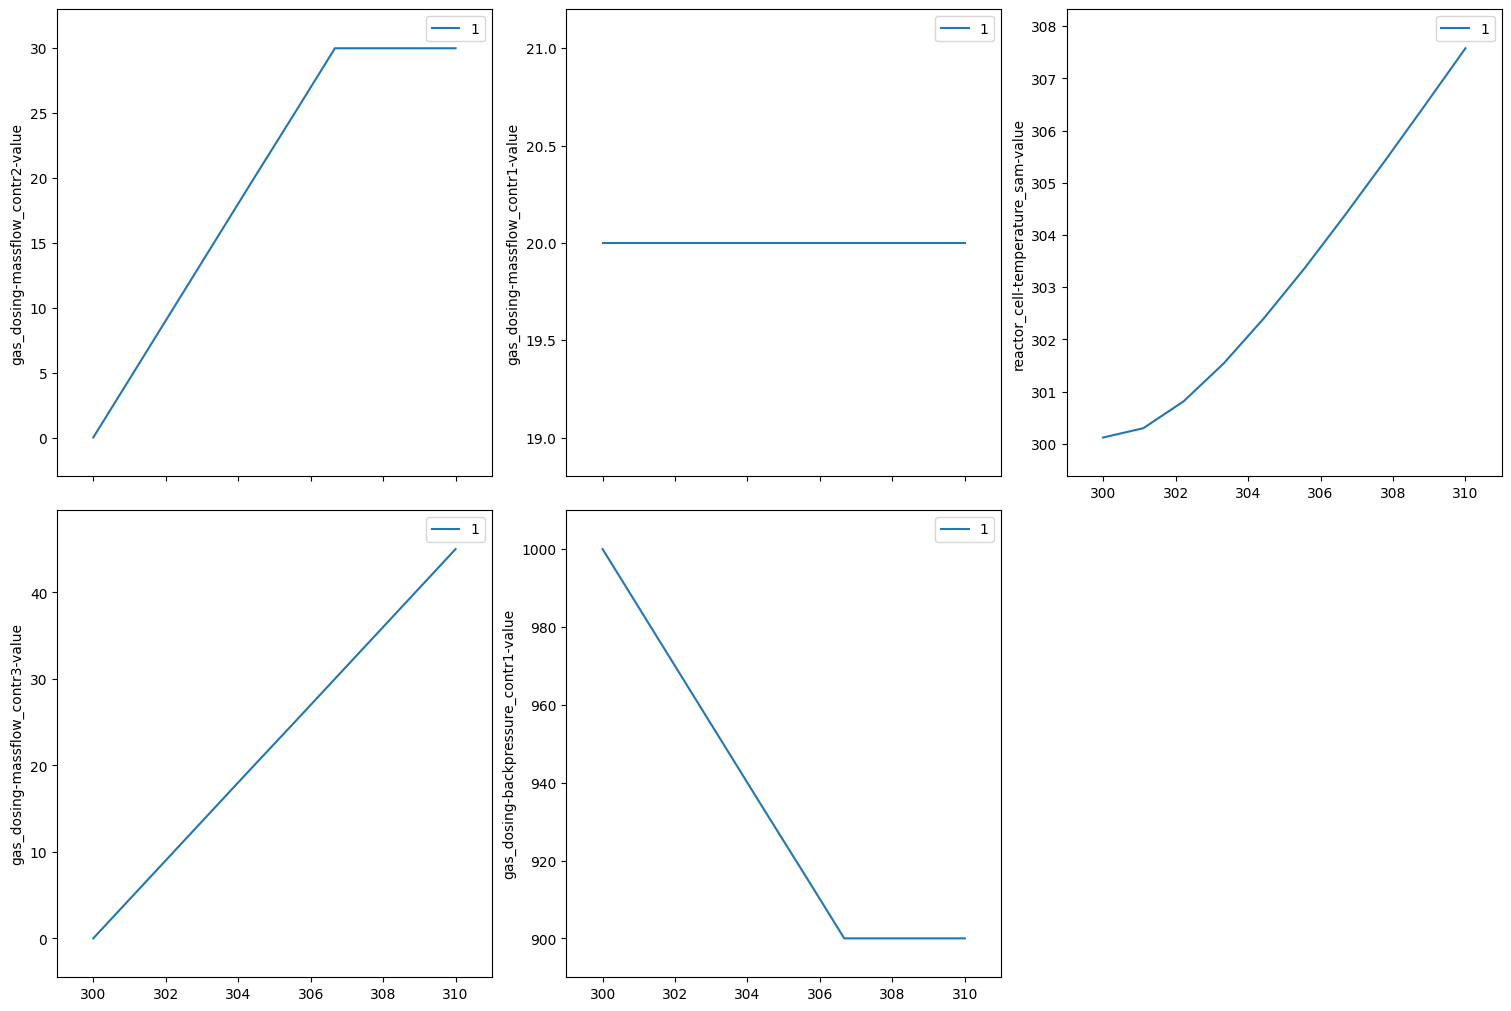

In [2]:
# Example of a scan plan:



def test_plan():
    yield from bps.abs_set(gas_dosing.backpressure_contr1,1000,wait=False,group='start')
    yield from bps.abs_set(reactor_cell.temperature_reg,300,wait=False,group='start')
    yield from bps.abs_set(gas_dosing.massflow_contr1,20,wait=False,group='start')
    yield from bps.abs_set(gas_dosing.massflow_contr2,0,wait=False,group='start')
    yield from bps.abs_set(gas_dosing.massflow_contr3,0,wait=False,group='start')

    yield from bps.wait(group='start')
    



    yield from bps.abs_set(gas_dosing.backpressure_contr1,900,wait=False)
    yield from bps.abs_set(gas_dosing.massflow_contr1,20,wait=False)
    yield from bps.abs_set(gas_dosing.massflow_contr2,30,wait=False)
    yield from bps.abs_set(gas_dosing.massflow_contr3,50,wait=False)

    yield from scan([
            reactor_cell.temperature_sam,
            gas_dosing.backpressure_contr1,
            gas_dosing.massflow_contr1,
            gas_dosing.massflow_contr2,
            gas_dosing.massflow_contr3
        ],
        reactor_cell.temperature_reg,300,310,10)


RE(test_plan())